# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestRegressor

#### Setting up fake data

In [2]:
num_of_sensors = 12
num_of_leaks = 11

The dimmensions for this test case is a square, just a demo

In [3]:
dim_lim_low = 24
dim_lim_high = 112

## Create x and y locations

This code is just needed for the test, in the real analysis, this will use C Becker's data sampling scheme

In [4]:
x_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)
y_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)

Let's make a fake z

In [5]:
random_values = np.random.uniform(-0.5, 0.5, num_of_sensors)
z_sensors = 2*np.sin(np.sqrt(x_sensors**2 + y_sensors**2)) + 0.5*np.cos(np.sqrt(x_sensors**2 + y_sensors**2)+2) + 5 + random_values*0.25

Text(0.5, 1.0, 'Fake sensor measurements')

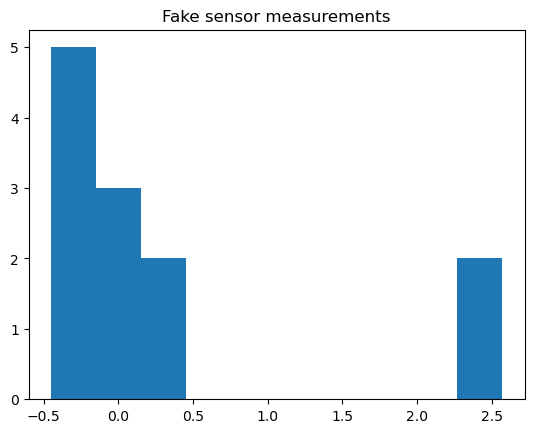

In [27]:
z_sensors = z_sensors - np.median(z_sensors)
plt.hist(z_sensors)
plt.title('Fake sensor measurements')

In [7]:
cut_in = 4 # just a parameter to get the leaks towards the middle of the plane

x_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)
y_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)

#### Quick Plot

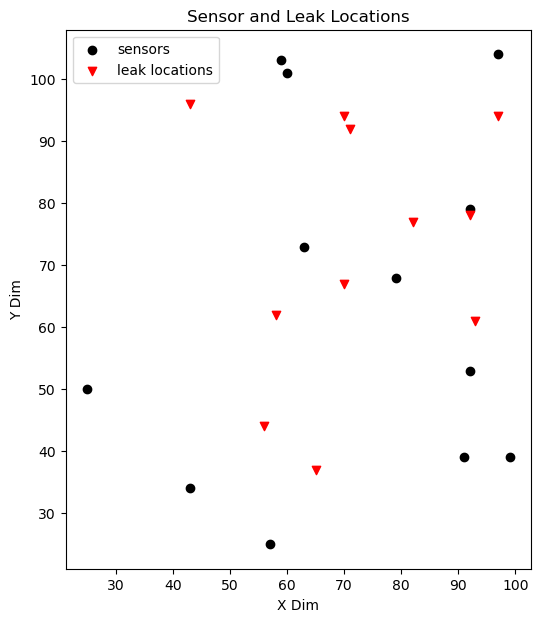

In [8]:
plt.figure(figsize=(6, 7))

plt.scatter(x_sensors, y_sensors, label='sensors', color='black')
plt.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')

plt.legend()
plt.xlabel('X Dim')
plt.ylabel('Y Dim')
plt.title('Sensor and Leak Locations')

plt.show()

This is just for this toy problem, won't be used for the actual code as it will come from the data loader as built by C Becker.

## Interpolate the Data

In [9]:
%%time

# Creating a grid of points for interpolation

buffer = 6 # adding some padding to make sure to capture the entire field

x_new, y_new = np.mgrid[min(x_sensors-buffer):max(x_sensors+buffer):100j, min(y_sensors-buffer):max(y_sensors+buffer):100j]

CPU times: user 1.16 ms, sys: 315 µs, total: 1.47 ms
Wall time: 1.03 ms


#### Using SciPy griddata

In [10]:
%%time

# Performing 2D interpolation
z_interpolated = griddata((x_sensors, y_sensors), z_sensors, (x_new, y_new), method='cubic')

# Finding Global Max and it's indicies
max_z = np.nanmax(z_interpolated)
max_indices = np.where(max_z == z_interpolated)

CPU times: user 3.53 ms, sys: 170 µs, total: 3.7 ms
Wall time: 2.31 ms


#### Using Scikit-learn methods

This uses the scikit-learn API:# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

In [11]:
# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

#### Gaussian Processes Regressor

In [12]:
%%time

# Define the kernel for Gaussian Process (RBF kernel is used here)
kernel = RBF(length_scale=10) # length scale could be adjusted

# Create the Gaussian Process Regressor
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the model with the data
gp_model.fit(X_train, y_train)

# Make some test data
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

# Predict interpolated values
interpolated_values_gp, std = gp_model.predict(X_test, return_std=True)
reshaped_gp_results = interpolated_values_gp.reshape(100,100)

# Finding Global Max and it's indicies using the gaussian process model
max_z_gp = np.nanmax(reshaped_gp_results)
max_indices_gp = np.where(max_z_gp == reshaped_gp_results)

CPU times: user 19.4 ms, sys: 19.1 ms, total: 38.4 ms
Wall time: 61.4 ms


#### Random Forest Model

Maybe can add wind (U, V, W, etc.) to this model? This should be slow, but might be better for rough / less smooth data sets. 

In [13]:
%%time
# Create the Random Forest Regressor with max depth set to 2
rf_model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=42)

# Fit the model with the data
rf_model.fit(X_train, y_train)

# Make some test data
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

# Predict interpolated values
interpolated_values_rf = rf_model.predict(X_test)
reshaped_rf_results = interpolated_values_rf.reshape(100, 100)

# Finding Global Max and its indices using the Random Forest model
max_z_rf = np.nanmax(reshaped_rf_results)
max_indices_rf = np.unravel_index(np.argmax(reshaped_rf_results), reshaped_rf_results.shape)

CPU times: user 48.5 ms, sys: 47.9 ms, total: 96.5 ms
Wall time: 109 ms


## Find which sensor has the highest value

In [14]:
def find_closest_value(arr1, arr2):
    closest_values = []

    for val1 in arr1:
        closest_val = min(arr2, key=lambda x: abs(x - val1))
        closest_values.append(closest_val)

    return closest_values

In [15]:
closest_values_x = find_closest_value(x_leaks, x_new[:,0])
closest_values_x

[70.25252525252526,
 56.35353535353536,
 58.09090909090909,
 71.12121212121212,
 97.18181818181819,
 70.25252525252526,
 82.41414141414143,
 91.96969696969697,
 43.323232323232325,
 92.83838383838385,
 65.04040404040404]

In [16]:
closest_values_y = find_closest_value(y_leaks, y_new[0,:])
closest_values_y

[66.79797979797979,
 43.81818181818182,
 62.2020202020202,
 91.61616161616162,
 94.37373737373737,
 94.37373737373737,
 76.9090909090909,
 77.82828282828282,
 96.21212121212122,
 61.282828282828284,
 37.38383838383838]

In [17]:
def find_indices(arr, values_to_find):
    indices = np.concatenate([np.where(arr == val)[0] for val in values_to_find])
    return indices

In [18]:
indices_x = find_indices(x_new[:,0], closest_values_x)
indices_x

array([59, 43, 45, 60, 90, 59, 73, 84, 28, 85, 53])

In [19]:
indices_y = find_indices(y_new[0,:], closest_values_y)
indices_y

array([52, 27, 47, 79, 82, 82, 63, 64, 84, 46, 20])

In [20]:
print("Which Leak location is most likely? - Using Standard Interpolator")
index_of_max_value = np.nanargmax(z_interpolated[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value)

Which Leak location is most likely? - Using Standard Interpolator
Index of the maximum value (ignoring NaN) is: 7


In [21]:
print("Which Leak location is most likely - Using Gaussian processes?")
index_of_max_value_gp = np.nanargmax(reshaped_gp_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_gp)

Which Leak location is most likely - Using Gaussian processes?
Index of the maximum value (ignoring NaN) is: 7


In [22]:
print("Which Leak location is most likely - Using Random Forest?")
index_of_max_value_rf = np.nanargmax(reshaped_rf_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_rf)

Which Leak location is most likely - Using Random Forest?
Index of the maximum value (ignoring NaN) is: 7


## Comparison Plot

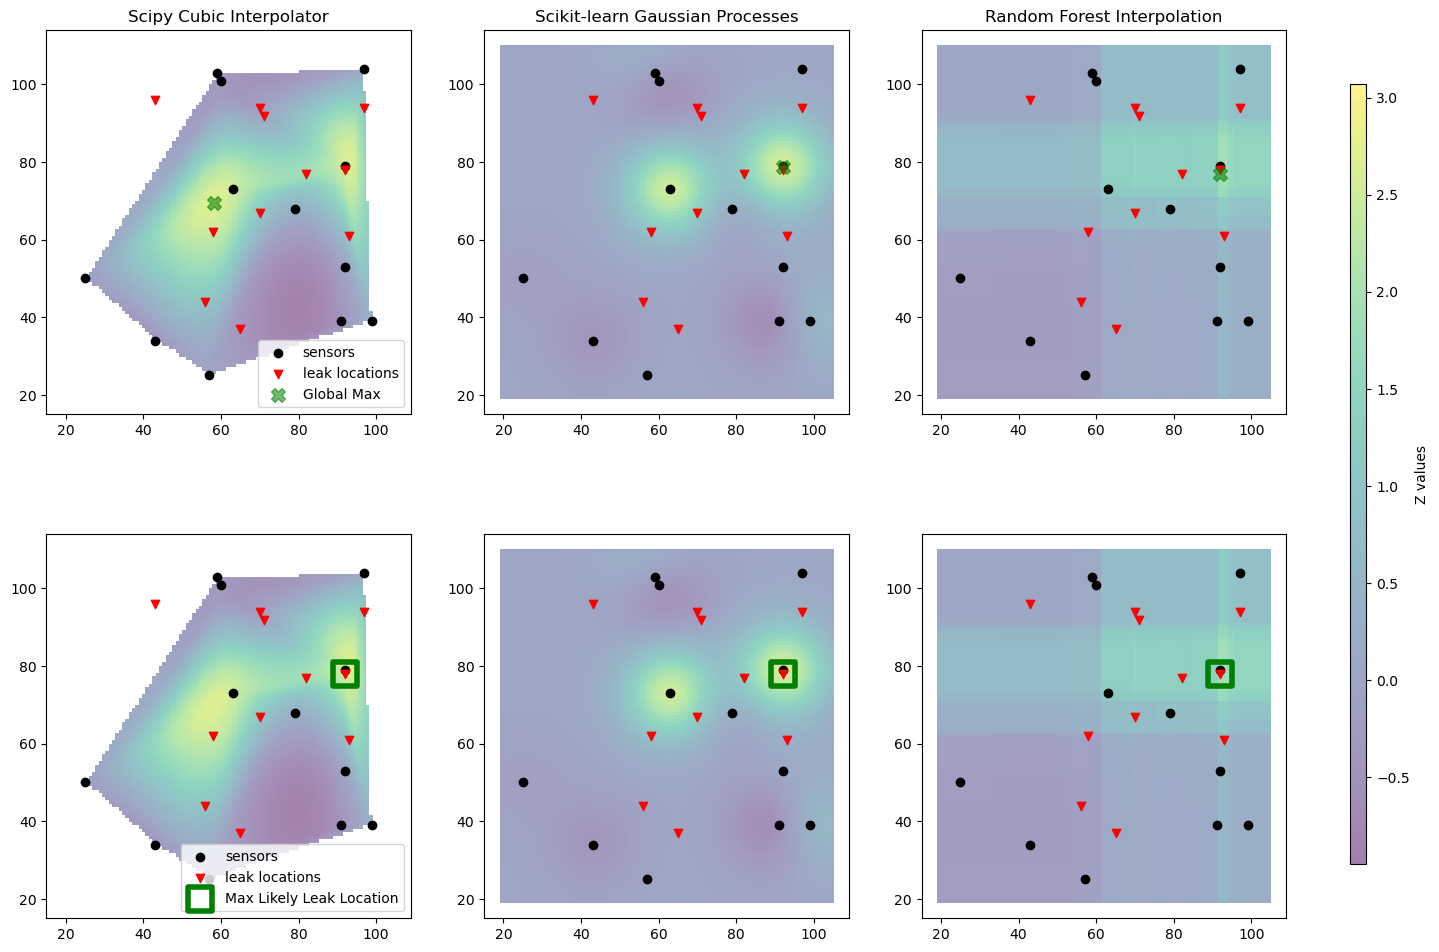

In [28]:
# Calculate the overall minimum and maximum values for the color bar range
global_min = np.round(np.min(z_sensors),2)-0.5
global_max = np.round(np.max(z_sensors),2)+0.5

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# Common settings for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.scatter(x_sensors, y_sensors, label='sensors', color='black')
        ax.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')
        ax.set_xlim(min(x_sensors-buffer-4), max(x_sensors+buffer+4))
        ax.set_ylim(min(y_sensors-buffer-4), max(y_sensors+buffer+4))
        # ax.set_clim(global_min, global_max)  # Set color bar range

        
# Plot 1 - First Block
img = axes[0,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img.set_clim(global_min, global_max)  # Set color bar range

axes[0, 0].scatter(x_new[max_indices[0][0]][0], y_new[0][max_indices[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 0].legend()
axes[0, 0].set_title('Scipy Cubic Interpolator')

# Plot 2 - Second Block

img2 = axes[0,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img2.set_clim(global_min, global_max) 

axes[0, 1].scatter(x_new[max_indices_gp[0][0]][0], y_new[0][max_indices_gp[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 1].set_title('Scikit-learn Gaussian Processes')

# Plot 4 - Third Block
img4 = axes[1,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img4.set_clim(global_min, global_max) 

axes[1, 0].scatter(x_leaks[index_of_max_value], y_leaks[index_of_max_value], marker="s", label='Max Likely Leak Location', color='Green', facecolors='none', s=300, linewidths=4)
axes[1, 0].legend()

# Plot 5 - Fourth Block
img5 = axes[1,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img5.set_clim(global_min, global_max) 
axes[1, 1].scatter(x_leaks[index_of_max_value_gp], y_leaks[index_of_max_value_gp], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)

# Third Across
img3 = axes[0,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img3.set_clim(global_min, global_max) 

axes[0, 2].scatter(x_new[max_indices_rf[0]][0], y_new[0][max_indices_rf[1]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 2].set_title('Random Forest Interpolation')

# Third Across, second row
img6 = axes[1,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img6.set_clim(global_min, global_max) 

axes[1, 2].scatter(x_leaks[index_of_max_value_rf], y_leaks[index_of_max_value_rf], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)


# Add colorbar
cbar_ax = fig.add_axes([.94, 0.17, 0.01, 0.65])  # [x, y, width, height]
cbar = plt.colorbar(img, cax=cbar_ax)
cbar.set_label('Z values')

# plt.tight_layout()
plt.show()